# Liang_2020

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Subset
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Figure 4 in page 17

Load dataset.

In [2]:
transform = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])
train_data = datasets.MNIST(
    './data', 
    download=True, 
    train=True, 
    transform=transform
)
test_data = datasets.MNIST(
    './data', 
    download=True, 
    train=False, 
    transform=transform
)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=len(train_data), shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data), shuffle=False)
x_train, y_train = next(iter(train_loader))
x_test, y_test = next(iter(test_loader))

Some necessary functions.

In [3]:
def filter_pairs(pair, x_train, y_train, x_test, y_test):
    target_labels = torch.tensor(pair)
    mask_train = (y_train == target_labels[0]) | (y_train == target_labels[1])
    x_train_filtered = x_train[mask_train]
    y_train_filtered = y_train[mask_train]
    y_train_filtered = torch.where(y_train_filtered == target_labels[0], 1, -1)
    mask_test = (y_test == target_labels[0]) | (y_test == target_labels[1])
    x_test_filtered = x_test[mask_test]
    y_test_filtered = y_test[mask_test]
    y_test_filtered = torch.where(y_test_filtered == target_labels[0], 1, -1)
    return x_train_filtered, y_train_filtered, x_test_filtered, y_test_filtered

In [5]:
# return error defined in page 16
def KRR(x_train, y_train, x_test, y_test, pair, kernel_fn, lambda_=0):
    # normalize
    x_train_new, y_train_new, x_test_new, y_test_new = filter_pairs(pair, x_train, y_train, x_test, y_test)
    x_train_new = x_train_new.view(x_train_new.size(0), -1)
    x_test_new = x_test_new.view(x_test_new.size(0), -1)
    # kernel matrix
    n = x_train_new.shape[0]
    K = kernel_fn(x_train_new, x_train_new)
    K = K + torch.eye(n) * lambda_
    K_inverse = torch.inverse(K)
    weights = K_inverse @ y_train_new.float().unsqueeze(1)
    y_hat = kernel_fn(x_test_new, x_train_new) @ weights
    mse = torch.sum((y_hat - y_test_new.float().unsqueeze(1)) ** 2)
    error = mse / torch.sum((y_test_new.float() - np.mean(y_test_new.numpy())) ** 2)
    print(f"pair={pair},lambda={lambda_:.2f},mse={mse:.2f},error={error:.4f}")
    return float(error)

Note that I used kernel function written in the package eigenpro2, corresponding paper is in the references. Run following code to download.

In [5]:
# !pip install git+https://github.com/EigenPro/EigenPro-pytorch.git

Plot figure4. We set bandwidth $\sigma$ s.t. $2\sigma^2=784$.

In [30]:
from eigenpro2.kernels import gaussian
kernel_fn = lambda x, z: gaussian(x, z, bandwidth=np.sqrt(784 / 2))
lambdas = [0, 0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28]
pairs = [(3, 6), (4, 9), (4, 5), (2, 7), (1, 8)]
results = {pair: [] for pair in pairs}
for pair in pairs:
    for lambda_ in lambdas:
        error = KRR(x_train, y_train, x_test, y_test, pair, kernel_fn, lambda_)
        results[pair].append(error)

pair=(3, 6),lambda=0.00,mse=23.13,error=0.0118
pair=(3, 6),lambda=0.01,mse=23.41,error=0.0119
pair=(3, 6),lambda=0.02,mse=23.72,error=0.0121
pair=(3, 6),lambda=0.04,mse=24.34,error=0.0124
pair=(3, 6),lambda=0.08,mse=25.48,error=0.0130
pair=(3, 6),lambda=0.16,mse=27.42,error=0.0139
pair=(3, 6),lambda=0.32,mse=30.50,error=0.0155
pair=(3, 6),lambda=0.64,mse=35.15,error=0.0179
pair=(3, 6),lambda=1.28,mse=41.98,error=0.0213
pair=(4, 9),lambda=0.00,mse=110.92,error=0.0557
pair=(4, 9),lambda=0.01,mse=108.30,error=0.0544
pair=(4, 9),lambda=0.02,mse=107.74,error=0.0541
pair=(4, 9),lambda=0.04,mse=108.07,error=0.0543
pair=(4, 9),lambda=0.08,mse=110.08,error=0.0553
pair=(4, 9),lambda=0.16,mse=114.75,error=0.0576
pair=(4, 9),lambda=0.32,mse=123.21,error=0.0619
pair=(4, 9),lambda=0.64,mse=136.87,error=0.0688
pair=(4, 9),lambda=1.28,mse=157.44,error=0.0791
pair=(4, 5),lambda=0.00,mse=23.79,error=0.0127
pair=(4, 5),lambda=0.01,mse=24.20,error=0.0129
pair=(4, 5),lambda=0.02,mse=24.65,error=0.0132
pair

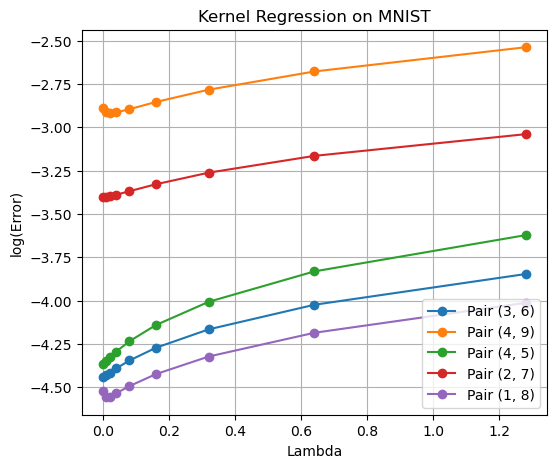

In [33]:
plt.figure(figsize=(6, 5))
for pair in pairs:
    log_errors = np.log(results[pair])
    plt.plot(lambdas, log_errors, marker='o', label=f'Pair {pair}')
plt.xlabel('Lambda')
plt.ylabel('log(Error)')
plt.title('Kernel Regression on MNIST')
plt.legend()
plt.grid(True)
plt.show()

No regularization generalize better? I question it here. Without slight regularization, the error explodes. Other results are the same with the paper. In fact, in the origin paper, similar phenomenon can be observed in pair (4,9).

## Figure 8 in page 18

Default test sample size is 1000.

In [10]:
# def Generate_Sigma(d, kappa):
#     j = torch.arange(1, d+1)
#     eigenvalues = (1 - ((j - 1) / d) ** kappa) ** (1 / kappa)
#     Sigma_diag = torch.diag(eigenvalues)
#     Q, _ = torch.linalg.qr(torch.randn(d, d))
#     # Sigma = Q * Sigma_diag * Q.T
#     Sigma = Q @ Sigma_diag @ Q.T
#     return Sigma
from eigenpro2.kernels import gaussian
def Generate_Eigens(d, kappa):
    j = torch.arange(1, d+1)
    eigenvalues = (1 - ((j - 1) / d) ** kappa) ** (1 / kappa)
    return eigenvalues

In [11]:
def KRR_syn(d, n, kappa, eigens, kernel_fn, Q, sigma=0.5, L=100, n_test=1000):
#     n_test = int(n * train_test_ratio)
    theta_l = torch.randn(L, d)
    Z = torch.randn(n, d)
    Z_test = torch.randn(n_test, d)
#     Q, _ = torch.linalg.qr(torch.randn(d, d))
    S = torch.diag(torch.sqrt(eigens))
#     A = torch.linalg.cholesky(Sigma)
#     X = Z @ A.T
#     X_test = Z_test @ A.T
#     U, S, V = torch.linalg.svd(Sigma)
#     X = Z @ U @ torch.diag(S.sqrt())
#     X_test = Z_test @ U @ torch.diag(S.sqrt())
    X = Z @ Q @ S
    X_test = Z_test @ Q @ S
    y = torch.sum(kernel_fn(X, theta_l), dim=1) + torch.randn(n) * sigma
    y_test = torch.sum(kernel_fn(X_test, theta_l), dim=1)
    K = kernel_fn(X, X)
    weights = torch.inverse(K) @ y.unsqueeze(1)
    y_hat = kernel_fn(X_test, X) @ weights
    mse = torch.sum((y_hat - y_test.unsqueeze(1)) ** 2)
    error = mse / torch.sum((y_test - np.mean(y_test.numpy())) ** 2)
    print(f"d={d},n={n},kappa={kappa:.2f},mse={mse:.2f},error={error:.4f}")
    return float(error)

### Fig 8.1

In [25]:
d = 200
e = np.exp(1)
kappas = np.linspace(1/e, e, 50)
ns = [4000, 2000, 1000, 240]
sigma = 0.5
results = {n: [] for n in ns}
# for n in ns:
#     for kappa in kappas:
#         kernel_fn = lambda x, z: gaussian(x, z, bandwidth=np.sqrt(d / 2))
#         Sigma = Generate_Sigma(d, kappa)
#         error = KRR_syn(d, n, kappa, kernel_fn=kernel_fn, Sigma=Sigma, sigma=sigma, train_test_ratio=1)
#         results[n].append(error)
import time
start_time = time.time()
Q, _ = torch.linalg.qr(torch.randn(d, d))
for n in ns:
    for kappa in kappas:
        kernel_fn = lambda x, z: gaussian(x, z, bandwidth=np.sqrt(d / 2))
        eigens = Generate_Eigens(d, kappa)
        error = KRR_syn(d, n, kappa, kernel_fn=kernel_fn, eigens=eigens, Q=Q, sigma=sigma)
        results[n].append(error)
end_time = time.time()
print("running time:", end_time - start_time, "s.")

d=200,n=4000,kappa=0.37,mse=461.92,error=1.6166
d=200,n=4000,kappa=0.42,mse=260.29,error=0.6344
d=200,n=4000,kappa=0.46,mse=164.61,error=0.2895
d=200,n=4000,kappa=0.51,mse=154.91,error=0.2122
d=200,n=4000,kappa=0.56,mse=125.02,error=0.1409
d=200,n=4000,kappa=0.61,mse=116.36,error=0.1073
d=200,n=4000,kappa=0.66,mse=95.51,error=0.0945
d=200,n=4000,kappa=0.70,mse=86.24,error=0.0649
d=200,n=4000,kappa=0.75,mse=81.40,error=0.0616
d=200,n=4000,kappa=0.80,mse=69.57,error=0.0474
d=200,n=4000,kappa=0.85,mse=63.11,error=0.0423
d=200,n=4000,kappa=0.90,mse=56.67,error=0.0350
d=200,n=4000,kappa=0.94,mse=55.26,error=0.0352
d=200,n=4000,kappa=0.99,mse=49.09,error=0.0292
d=200,n=4000,kappa=1.04,mse=44.82,error=0.0255
d=200,n=4000,kappa=1.09,mse=43.88,error=0.0263
d=200,n=4000,kappa=1.14,mse=43.20,error=0.0255
d=200,n=4000,kappa=1.18,mse=44.90,error=0.0258
d=200,n=4000,kappa=1.23,mse=40.41,error=0.0236
d=200,n=4000,kappa=1.28,mse=34.45,error=0.0171
d=200,n=4000,kappa=1.33,mse=39.67,error=0.0204
d=200,n

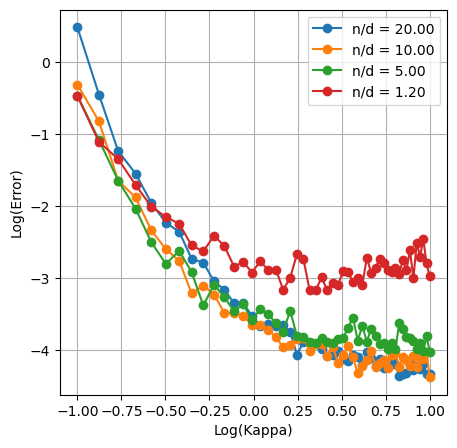

In [26]:
plt.figure(figsize=(5, 5))
for n in ns:
    log_kappas = np.log(np.maximum(np.array(kappas), 1e-5))
    log_results = np.log(np.maximum(np.array(results[n]), 1e-5))
    plt.plot(log_kappas, log_results, marker='o', label=f'n/d = {n/d:.2f}')
plt.xlabel('Log(Kappa)')
plt.ylabel('Log(Error)')
plt.legend()
plt.grid(True)
plt.show()

### Fig 8.2

In [12]:
e = np.exp(1)
n = 200
kappas = np.linspace(1/e, e, 50)
ds = [4000, 2000, 1000, 240]
sigma = 0.5
results = {d: [] for d in ds}
import time
start_time = time.time()
for d in ds:
    Q, _ = torch.linalg.qr(torch.randn(d, d))
    for kappa in kappas:
        kernel_fn = lambda x, z: gaussian(x, z, bandwidth=np.sqrt(d / 2))
        eigens = Generate_Eigens(d, kappa)
        error = KRR_syn(d, n, kappa, kernel_fn=kernel_fn, eigens=eigens, Q=Q, sigma=sigma)
        results[d].append(error)
end_time = time.time()
print("running time:", end_time - start_time, "s.")

d=4000,n=200,kappa=0.37,mse=41.34,error=3.1851
d=4000,n=200,kappa=0.42,mse=34.66,error=1.8305
d=4000,n=200,kappa=0.46,mse=30.69,error=1.1596
d=4000,n=200,kappa=0.51,mse=20.86,error=0.5963
d=4000,n=200,kappa=0.56,mse=18.20,error=0.3870
d=4000,n=200,kappa=0.61,mse=21.19,error=0.4432
d=4000,n=200,kappa=0.66,mse=29.39,error=0.5201
d=4000,n=200,kappa=0.70,mse=16.81,error=0.2586
d=4000,n=200,kappa=0.75,mse=46.35,error=0.6365
d=4000,n=200,kappa=0.80,mse=21.38,error=0.2597
d=4000,n=200,kappa=0.85,mse=53.52,error=0.6979
d=4000,n=200,kappa=0.90,mse=36.31,error=0.4344
d=4000,n=200,kappa=0.94,mse=42.84,error=0.5013
d=4000,n=200,kappa=0.99,mse=54.24,error=0.6421
d=4000,n=200,kappa=1.04,mse=59.82,error=0.6887
d=4000,n=200,kappa=1.09,mse=47.22,error=0.5263
d=4000,n=200,kappa=1.14,mse=51.51,error=0.5551
d=4000,n=200,kappa=1.18,mse=59.32,error=0.6898
d=4000,n=200,kappa=1.23,mse=38.05,error=0.4428
d=4000,n=200,kappa=1.28,mse=78.99,error=0.8717
d=4000,n=200,kappa=1.33,mse=73.63,error=0.7691
d=4000,n=200,

d=240,n=200,kappa=2.14,mse=134.41,error=0.0907
d=240,n=200,kappa=2.19,mse=169.88,error=0.1053
d=240,n=200,kappa=2.24,mse=126.02,error=0.0806
d=240,n=200,kappa=2.29,mse=132.60,error=0.0804
d=240,n=200,kappa=2.33,mse=151.80,error=0.0887
d=240,n=200,kappa=2.38,mse=138.04,error=0.0841
d=240,n=200,kappa=2.43,mse=124.45,error=0.0760
d=240,n=200,kappa=2.48,mse=196.05,error=0.1162
d=240,n=200,kappa=2.53,mse=96.12,error=0.0638
d=240,n=200,kappa=2.57,mse=108.43,error=0.0706
d=240,n=200,kappa=2.62,mse=126.79,error=0.0811
d=240,n=200,kappa=2.67,mse=113.60,error=0.0705
d=240,n=200,kappa=2.72,mse=131.62,error=0.0812
running time: 31.182986974716187 s.


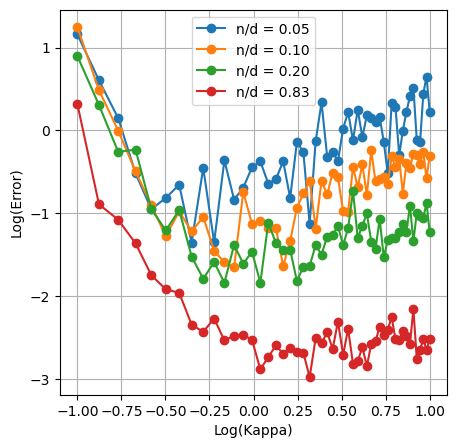

In [13]:
plt.figure(figsize=(5, 5))
for d in ds:
    log_kappas = np.log(np.maximum(np.array(kappas), 1e-5))
    log_results = np.log(np.maximum(np.array(results[d]), 1e-5))
    plt.plot(log_kappas, log_results, marker='o', label=f'n/d = {n/d:.2f}')
plt.xlabel('Log(Kappa)')
plt.ylabel('Log(Error)')
plt.legend()
plt.grid(True)
plt.show()

The fluctuation of the curve is probably related to the randomness of the noise. Repeat the former procedures several times as Monte Carlo we may finally obtain smoother curves.

In [ ]:
e = np.exp(1)
n = 200
kappas = np.linspace(1/e, e, 50)
ds = [4000, 2000, 1000, 240]
sigma = 0.5
results = {d: np.zeros(50) for d in ds}
num_trials = 50

start_time = time.time()
for d in ds:
    for trial in range(num_trials):
        Q, _ = torch.linalg.qr(torch.randn(d, d))
        for i, kappa in enumerate(kappas):
            kernel_fn = lambda x, z: gaussian(x, z, bandwidth=np.sqrt(d / 2))
            eigens = Generate_Eigens(d, kappa)
            error = KRR_syn(d, n, kappa, kernel_fn=kernel_fn, eigens=eigens, Q=Q, sigma=sigma)
            results[d][i] += error / num_trials

end_time = time.time()
print("running time:", end_time - start_time, "s.")

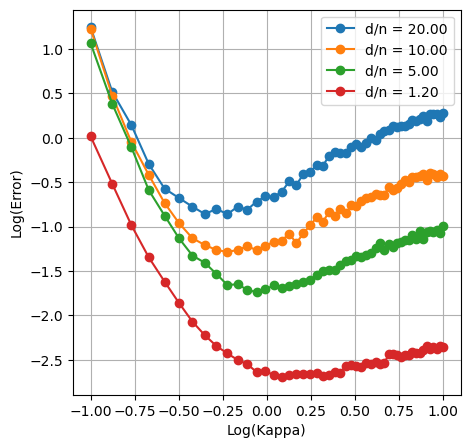

In [16]:
plt.figure(figsize=(5, 5))
for d in ds:
    log_kappas = np.log(np.maximum(np.array(kappas), 1e-5))
    log_results = np.log(np.maximum(results[d], 1e-5))
    plt.plot(log_kappas, log_results, marker='o', label=f'd/n = {d/n:.2f}')
plt.xlabel('Log(Kappa)')
plt.ylabel('Log(Error)')
plt.legend()
plt.grid(True)
plt.show()

## References

@misc{ma2019kernel,
      title={Kernel machines that adapt to GPUs for effective large batch training}, 
      author={Siyuan Ma and Mikhail Belkin},
      year={2019},
      eprint={1806.06144},
      archivePrefix={arXiv},
      primaryClass={stat.ML}
}